# 02 Automatic Rendering

In [4]:
import os
import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as D
import pyro.distributions.constraints as C

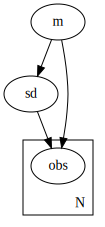

In [5]:
def model(data):
    m = pyro.sample('m', D.Normal(0, 1))
    sd = pyro.sample('sd', D.LogNormal(m, 1))
    with pyro.plate('N', len(data)):
        return pyro.sample('obs', D.Normal(m, sd))
    
pyro.render_model(model, model_args=(torch.ones(1), ))

In [48]:
def mace(positions, annotations):
    nannotators = int(torch.max(positions)) + 1
    nclasses = int(torch.max(annotations)) + 1
    num_items, num_positions = annotations.shape
    
    with pyro.plate('annotator', nannotators):
        epsilon = pyro.sample("ε", D.Dirichlet(torch.full((nclasses,), 10.)))
        theta = pyro.sample("θ", D.Beta(0.5, 0.5))
        
    with pyro.plate("item", num_items, dim=-2):
        # NB: using constant logits for discrete uniform prior
        # (NumPyro does not have DiscreteUniform distribution yet)
        c = pyro.sample("c", D.Categorical(logits=torch.zeros(nclasses)))

        with pyro.plate("position", num_positions):
            s = pyro.sample("s", D.Bernoulli(1 - theta[positions]))
            probs = torch.where(
                s[..., None] == 0, F.one_hot(c, nclasses).float(), epsilon[positions]
            )
            pyro.sample("y", D.Categorical(probs), obs=annotations)
        
        
mace_graph = pyro.render_model(mace, model_args=(torch.ones(7).type(torch.long), torch.ones(45, 7)))    

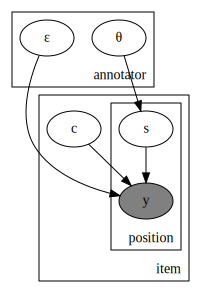

In [49]:
mace_graph

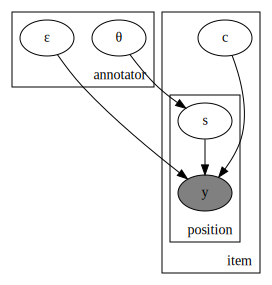

In [50]:
mace_graph.unflatten(stagger=2)